In [1]:
import sys
sys.path.insert(0,'..')
sys.path.insert(0,'../../WobbleSim')
import simulacra.dataset
import astropy
import astropy.units as u 
import astropy.coordinates as coord
import astropy.time as at
import astropy.constants as const
import numpy as np

import jabble.dataset
import jabble.loss
import jabble.model

import matplotlib.pyplot as plt

<h1>31 - Take data from straight flying star</h1>

In [2]:
filename = '/scratch/mdd423/simulacra/out/2022-02-02/data_e40_R130000.0_a10.0_p7.0_l7.0e+039.5e+03_snr250.0.h5.h5'
# data = simulacra.dataset.from_h5(filename)

In [3]:
# wob_data = jabble.dataset.Dataset.from_flux(data['data']['wave'],data['data']['flux'],data['data']['ferr'],data['data']['mask'])

In [4]:
import scipy.ndimage
def normalize(y,sigma):
    y_low = scipy.ndimage.gaussian_filter(y,sigma)
    return y_low

In [5]:
data    = simulacra.dataset.from_h5(filename)
# simulacra.dataset.print_keys(data)
epoches = data['data']['flux'].shape[0]

# masks = np.array(data['data']['mask'],dtype=bool)
wave = np.repeat(np.array(data['data']['wave'])[np.newaxis,:],epoches,axis=0) * u.Angstrom
flux = np.array(data['data']['flux'])
ferr = np.array(data['data']['ferr'])

masks = np.array(data['data']['mask'],dtype=bool)
masks = np.logical_or(np.isnan(ferr), masks)
masks = np.logical_or(np.isnan(flux), masks)
masks = np.logical_or(flux <= 0, masks)
print(np.where(np.isnan(ferr)))
print(np.where(masks))
# masks = np.isnan(ferr)

sigma = 110
dataset = jabble.dataset.Dataset.from_flux(wave,flux,ferr,masks,normalize,nargs=[sigma])
dataset.set_mask(0.0,10.0)

obs_times = data['data']['obs_times']
times = at.Time(obs_times)

loc    = data['parameters']['detector']['loc']
target = data['parameters']['star']['target']
resolution = float(data['parameters']['detector']['_resolution'][()])

period = (data['parameters']['star']['period'])
bc = target.radial_velocity_correction(obstime=times[-1],location=loc).to(u.km/u.s)
rv = data['data']['rvs'].to(u.km/u.s)
snr = np.mean(data['data']['snr_readout'][~np.isnan(data['data']['snr_readout'])])

<HDF5 dataset "obs_times": shape (40,), type "|O">
(array([ 0,  0,  0, ..., 39, 39, 39]), array([131646, 148182, 148184, ..., 158496, 158657, 158658]))
(array([ 0,  0,  0, ..., 39, 39, 39]), array([131646, 148182, 148184, ..., 158496, 158657, 158658]))


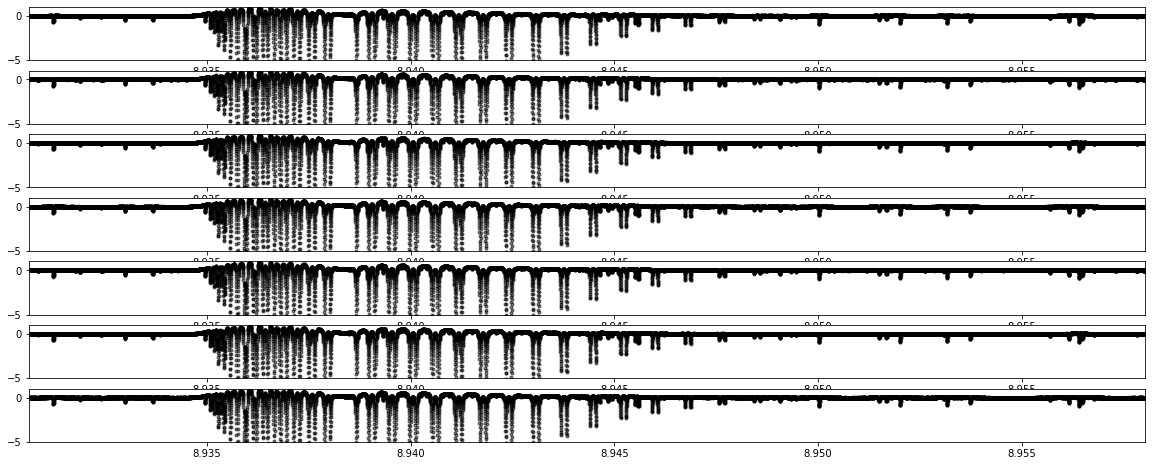

In [15]:
plt_inds = 7
xpmin = np.log(7560)
xpmax = np.log(7770)
fig, axes = plt.subplots(plt_inds,figsize=(20,8))
for ele in range(plt_inds):
    axes[ele].errorbar(dataset.xs[j,:],dataset.ys[j,:],dataset.yerr[j,:],fmt='.k',elinewidth=2.2,zorder=1,alpha=0.5,ms=6)
    axes[ele].set_xlim(xpmin,xpmax)
    axes[ele].set_ylim(-5,1)
plt.show() 

In [7]:
loss = jabble.loss.ChiSquare()
init_vels = np.linspace(-300,300,epoches) * u.km/u.s
init_shifts = jabble.dataset.shifts(init_vels)

In [8]:
vel_padding = 4 * u.km/u.s
x_grid = jabble.model.create_x_grid(dataset.xs,vel_padding,resolution)#step=jabble.dataset.shifts(const.c.to(u.km/u.s)/resolution))
stellar_model = jabble.model.CompositeModel([jabble.model.ShiftingModel(init_shifts),jabble.model.JaxLinear(x_grid)])

2022-02-03 12:23:52.298033: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/.singularity.d/libs
2022-02-03 12:23:52.298055: W external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


In [9]:
def train_cycle(model,data,loss,fit1_inds,fit2_inds,maxiter1,maxiter2):
    # Fitting Round 1
    print('fitting round 1')
    model.fix()
    for ind in fit1_inds:
        model.fit(*ind)
    res1 = model.optimize(loss,data,maxiter1)
    model.fix()
    
    # Fitting Round 2
    print('fitting round 2')
    model.fix()
    for ind in fit2_inds:
        model.fit(*ind)
    res2 = model.optimize(loss,data,maxiter2)
    return model

In [10]:
ind1 = [[1]]
iter1= 32
ind2 = [[0],[1]]
iter2= 64
stellar_model = train_cycle(stellar_model,dataset,loss,ind1,ind2,iter1,iter2)

fitting round 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39703     M =           10


 This problem is unconstrained.


fitting round 2
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39703     25     46      1     0     0   1.204D+08   1.923D+12

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             




   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39743     M =           10


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39743      6     35      1     0     0   3.279D+13   1.893D+12

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [11]:
import matplotlib.pyplot as plt

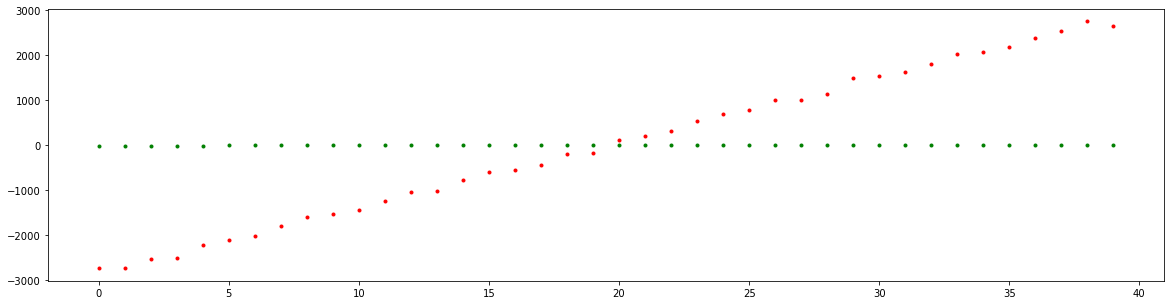

In [12]:
plt.figure(figsize=(20,5))
plt.plot(rv - init_vels,'.g')
plt.plot(jabble.dataset.velocities(stellar_model[0].p) - init_vels,'.r')

In [13]:
def norm_func(y,sigma):
    y_low = scipy.ndimage.gaussian_filter(y,sigma)
    return y_low/y

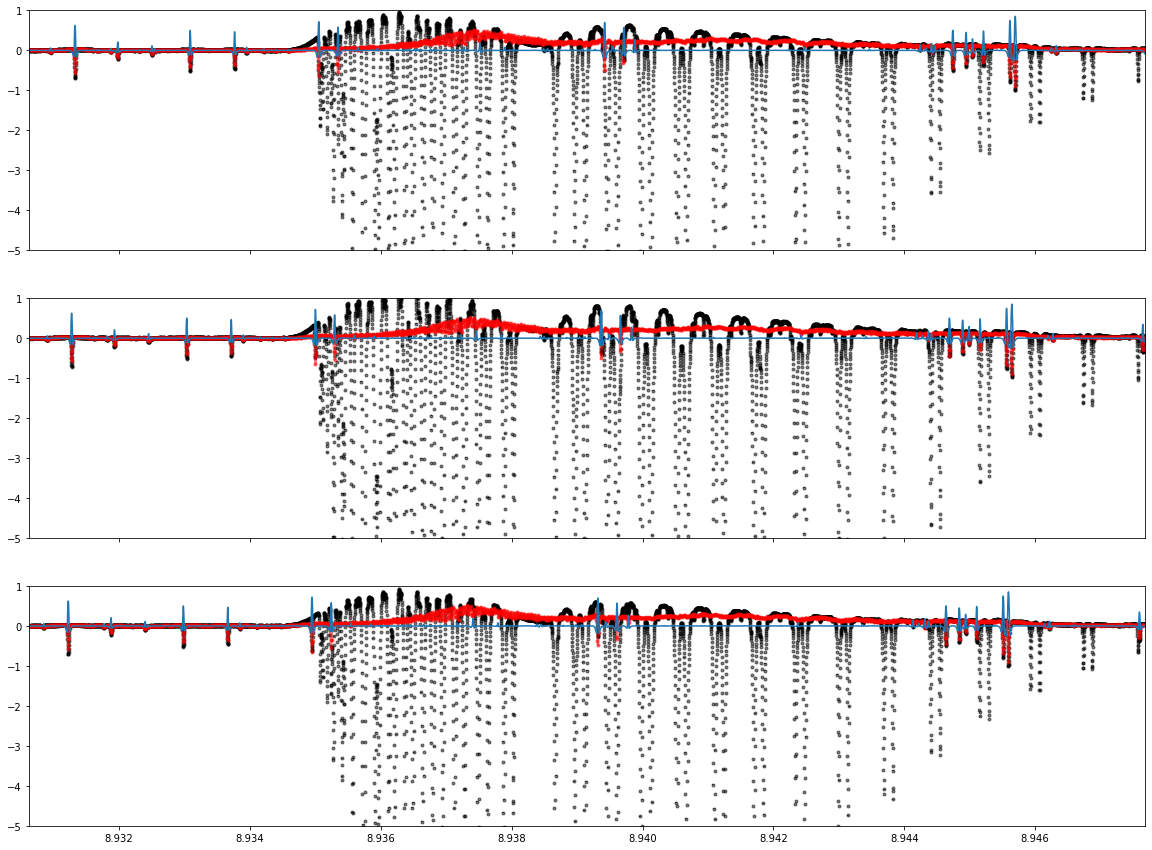

In [14]:
xpmin = np.log(7560)
xpmax = np.log(7690)
plt_unit = u.Angstrom
plt_epoch = 3
fig, axes = plt.subplots(plt_epoch,figsize=(20,15),sharex=True,sharey=True,facecolor=(1, 1, 1))
for j in range(plt_epoch):
#         datasets[i].plot_star(axes[i,j],j,xy='xy',units=plt_unit,normalize=normalize_2,nargs=[sigma])
#     data.plot_tellurics(axes[i],i,xy='xy',units=plt_unit)

    axes[j].errorbar(dataset.xs[j,:],dataset.ys[j,:],dataset.yerr[j,:],fmt='.k',elinewidth=2.2,zorder=1,alpha=0.5,ms=6)
    axes[j].plot(stellar_model[1].xs-stellar_model[0].p[j],stellar_model[1].p,'.r',linestyle='solid',linewidth=2.2,zorder=2,alpha=0.5,ms=6)
    axes[j].set_xlim(xpmin,xpmax)
    axes[j].set_ylim(-5,1)
    axes[j].plot(np.log(data['theory']['interpolated']['total']['wave'].to(u.Angstrom).value),np.log(norm_func(data['theory']['interpolated']['star']['flux'][j,:],sigma)))
    
plt.savefig('../out/star_plots.png',dpi=300,bbox_inches='tight')
plt.show()